## Start with a markov model 

In [46]:
import numpy as np

# position 0 is always an absorbing state

# a transition matrix would satisfy, each row sums to 1

# for convenience, N will indicate N potential products, but the actual matrix will be (n+1)*(n+1) due to potision 0
def gen_transition(N):
    base = np.identity(N+1)
    
    sub_M = np.random.uniform(low=0., high=1, size=(N, N))
    
    sub_M[sub_M < 1 - 1/np.sqrt(N)]=0   # to maintain a sparse structure
    
    base[1:N+1,1:N+1] = sub_M
    
    base[1:N+1,0] = np.random.uniform(low=0.1, high=0.3, size = N)
    
    base = base / base.sum(axis=1, keepdims = True)
    
    return base

# share the probability on diagonal to other places
def gen_transition_nodiag(N):
    mat = gen_transition(N)
    for i in range(1,N+1):
        mat[i,i]=0
        
    mat = mat / mat.sum(axis=1, keepdims = True)
    return mat

# utilitiy, from probability vector to index_indicator
def indicator(probs):
    if not sum(probs) > 1.0 - 1e-6 and sum(probs) < 1.0 + 1e-6:
        print("WRONG PROBABILITY!")
        return
    index = np.random.choice(len(probs), 1, p=probs)[0]
    indicate = np.zeros(len(probs))
    indicate[index] = 1
    return indicate


# transition matrix should be given in advance, for sure!
# given an assortment, generate a hitting sample
def single_sample_generator(Lams, TransP, Assorts):
    Lams = np.insert(Lams, 0, 0)
    Assorts = np.insert(Assorts, 0, 0)
    choice = indicator(Lams)
    while True:
        if choice[0] == 1 or np.dot(choice, Assorts)>0:
            return choice
        else:
            choice_prob = TransP[np.squeeze(np.argwhere(choice == 1))]
            choice = indicator(choice_prob)

def multi_sample_generator(Lams, TransP, Assorts, sampleN):
    N = len(Lams)
    choices = np.zeros((sampleN,N+1))
    for i in range(sampleN):
        choices[i] = single_sample_generator(Lams, TransP, Assorts)
        
    return choices
    
# the exact probability for product choice    
def actual_prob(Lams, TransP, Assorts):
    Lams = np.insert(Lams, 0, 0)
    Assorts = np.insert(Assorts, 0, 1)
    S_plus = np.squeeze(np.argwhere(Assorts == 1),axis=1)
    S_bar = np.squeeze(np.argwhere(Assorts == 0),axis=1)
    B = TransP[np.expand_dims(S_bar, axis=1), S_plus]
    C = TransP[np.expand_dims(S_bar, axis=1), S_bar]
    
    distri = np.zeros(len(Lams))
    
    addi = np.matmul(np.matmul(np.expand_dims(Lams[S_bar], axis=0), np.linalg.inv(np.identity(len(C)) - C)), B)
    
    count = 0
    for i in S_plus:
        distri[i] = Lams[i] + addi[0,count]
        count += 1
    
    return distri
    
    

    
transP = gen_transition_nodiag(4)
lams = np.array([0.1,0.4,0.3,0.2])
assortment = np.array([0,1,1,0])
# bundle = np.squeeze(np.argwhere(assortment == 1))
actual_prob(lams, transP, assortment)

array([0.03810539, 0.        , 0.49523234, 0.46666227, 0.        ])

##  We use multi_sample_generator to test actual_prob

In [47]:
transP = gen_transition_nodiag(10)
lams = np.array([0.1]*10)
assortment = np.zeros(10)
assortment[[1,3,5,6,8]]=1
print(assortment)

# bundle = np.squeeze(np.argwhere(assortment == 1))
print(actual_prob(lams, transP, assortment))

data = np.sum(multi_sample_generator(lams, transP, assortment, 10000), axis=0)
data

[0. 1. 0. 1. 0. 1. 1. 0. 1. 0.]
[0.10532507 0.         0.26029582 0.         0.18388993 0.
 0.15390964 0.13728175 0.         0.1592978  0.        ]


array([1031.,    0., 2596.,    0., 1824.,    0., 1536., 1431.,    0.,
       1582.,    0.])

## After the checks above, we start building the network to check its representation power

### start with some experiments

In [18]:
import torch
import torch.nn as nn

# batch normalization
example = torch.randn((2,3,2,2))
print(example)
batch_layer = nn.BatchNorm2d(3)
print([para.data for para in batch_layer.parameters()])
output=batch_layer(example)
print(output)
channel0 = output[:,0,:,:].detach().numpy()
print(np.mean(channel0))
print(np.var(channel0))

tensor([[[[ 0.2530, -1.5013],
          [-1.2542,  1.4800]],

         [[-0.3728,  1.1849],
          [-0.7995, -1.5207]],

         [[ 0.3995,  1.7606],
          [ 0.0475,  0.0821]]],


        [[[-0.1104,  0.3872],
          [ 1.4053,  0.4585]],

         [[-0.0354, -1.5229],
          [ 0.5594, -1.9008]],

         [[-0.1361,  0.4570],
          [ 0.0560,  1.1091]]]])
[tensor([1., 1., 1.]), tensor([0., 0., 0.])]
tensor([[[[ 0.1114, -1.6138],
          [-1.3708,  1.3180]],

         [[ 0.1748,  1.7029],
          [-0.2438, -0.9513]],

         [[-0.1194,  2.1232],
          [-0.6994, -0.6424]]],


        [[[-0.2460,  0.2433],
          [ 1.2445,  0.3134]],

         [[ 0.5058, -0.9535],
          [ 1.0893, -1.3242]],

         [[-1.0018, -0.0247],
          [-0.6853,  1.0497]]]], grad_fn=<NativeBatchNormBackward0>)
1.4901161e-08
0.9999904


In [19]:
example = torch.randn((2,3,2,2))
print(example)
layer_norm = nn.LayerNorm((3,2,2))
output=layer_norm(example)
print(output)
batch0 = output[0,:,:,:].detach().numpy()
print(np.mean(batch0))
print(np.var(batch0))

tensor([[[[ 1.6710,  0.0407],
          [ 1.0089,  0.6703]],

         [[ 0.7476, -0.5383],
          [-0.4221, -1.3066]],

         [[-1.6165,  0.7378],
          [-0.9020, -0.2693]]],


        [[[ 0.0502,  0.5441],
          [ 1.3378, -0.4834]],

         [[-0.1206, -1.2273],
          [-0.5006,  0.2532]],

         [[ 2.1000, -0.8446],
          [ 0.9251,  1.0094]]]])
tensor([[[[ 1.7579e+00,  5.7929e-02],
          [ 1.0676e+00,  7.1446e-01]],

         [[ 7.9507e-01, -5.4582e-01],
          [-4.2461e-01, -1.3470e+00]],

         [[-1.6701e+00,  7.8486e-01],
          [-9.2507e-01, -2.6531e-01]]],


        [[[-2.1863e-01,  3.1225e-01],
          [ 1.1655e+00, -7.9228e-01]],

         [[-4.0226e-01, -1.5920e+00],
          [-8.1082e-01, -4.3100e-04]],

         [[ 1.9849e+00, -1.1806e+00],
          [ 7.2190e-01,  8.1247e-01]]]], grad_fn=<NativeLayerNormBackward0>)
1.4901161e-08
0.9999893


## consider a bottle neck structure, input assortment, output probabilities

In [57]:
import torch
import torch.nn as nn

class Bottleneck(nn.Module):
    
    def __init__(self, Veclen, Necklen):
        super(Bottleneck, self).__init__()
        
        self.fc1 = nn.Linear(Veclen, Necklen)
        
        self.bn1 = nn.BatchNorm1d(Necklen)
        
        self.fc2 = nn.Linear(Necklen, Necklen)
        
        self.bn2 = nn.BatchNorm1d(Necklen)
        
        self.fc3 = nn.Linear(Necklen, Veclen)
        
        self.bn3 = nn.BatchNorm1d(Veclen)
        
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        
        self.fc4 = nn.Linear(2,1)
        
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
        residual = torch.unsqueeze(x, 1)

        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.fc3(out)
        out = self.bn3(out)
        out = self.relu(out)

        out = torch.unsqueeze(out, 1)
        
        out = torch.cat((out,residual),1).permute(0,2,1)
        
        out = torch.squeeze(self.fc4(out),2)
        
        out = self.sigmoid(out)

        return out
        
N = 10
neck = 4
batchsize = 3
lams = np.array([0.1]*10)

sample = np.zeros((batchsize, N))
for i in range(batchsize):
    sample[i] = indicator(lams)

inp = torch.tensor(sample).float()

net = Bottleneck(N,neck)
print(net(inp))

tensor([[0.5822, 0.5352, 0.6441, 0.6425, 0.5476, 0.6013, 0.5168, 0.5637, 0.6328,
         0.5288],
        [0.5577, 0.6424, 0.5850, 0.6123, 0.6437, 0.6302, 0.6377, 0.5379, 0.5141,
         0.6415],
        [0.6441, 0.6135, 0.5553, 0.5354, 0.5946, 0.5161, 0.6296, 0.6443, 0.6351,
         0.5870]], grad_fn=<SigmoidBackward0>)


## training, with synthetic data generated

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

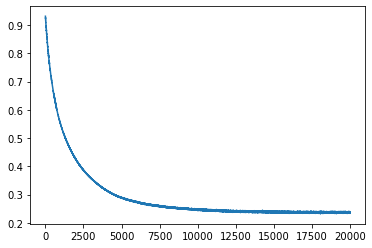

In [64]:
from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

N_prod = 10
Vec_Len = N_prod + 1
Neck_Len = 5
EPOCHS = 1000

transP = gen_transition_nodiag(N_prod)
lams = np.array([1/N_prod] * N_prod)
Training_Sample_Amount = 10000

INPUT = np.zeros((Training_Sample_Amount,Vec_Len))
OUTPUT = np.zeros((Training_Sample_Amount,Vec_Len))
for i in range(Training_Sample_Amount):
    # generate input vector, which has length vec_len
    # the first element is 0, which should be ignored when treated as an assortment
    potential_vec = np.random.uniform(low=0., high=1, size=Vec_Len)
    potential_vec[0] = 0
    potential_vec[potential_vec > 1/2] = 1
    potential_vec[potential_vec <= 1/2] = 0
    
    INPUT[i] = potential_vec
    OUTPUT[i] = actual_prob(lams, transP, potential_vec[1:])
    
created_dataset = TensorDataset(torch.Tensor(INPUT),torch.Tensor(OUTPUT))    
dataloader = DataLoader(created_dataset, shuffle=True, batch_size = 500)


model = Bottleneck(Vec_Len, Neck_Len)
optimizer = optim.Adam(model.parameters(), lr = 0.0005)
criterion = nn.BCELoss()


losses = []
for epo in range(EPOCHS):
    print(epo)
    for step, (IN, TEST) in enumerate(dataloader):
        OUT = model(IN)
        loss = criterion(OUT,TEST)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.detach().item())
    
plt.plot(losses)

## after the training, we try to predict a guy

In [78]:
Assort_Instance = np.array([1,1,0,0,1,1,1,1,1,0])



actu_prob = actual_prob(lams, transP, Assort_Instance)
print(actu_prob)

IN_VEC = torch.Tensor(
np.array([
    [0,1,1,0,0,0,1,1,0,1,0],
    [0,0,1,1,0,1,0,1,0,0,1]
])
)

OUT = model(IN_VEC)
print(OUT[0].detach().numpy())

[0.19333474 0.1        0.23349433 0.         0.         0.
 0.16882909 0.20434184 0.         0.1        0.        ]
[2.7229998e-01 1.6440183e-01 1.1338722e-02 2.0713727e-03 2.6742101e-03
 2.4091788e-03 1.8517564e-01 2.1767445e-01 5.9548969e-05 4.6196301e-03
 1.4507346e-04]


## somehow, looks, reasonable!